### 프로젝트 : 고양이 수염 붙이기

In [452]:
import cv2
import dlib
import os
import matplotlib.pyplot as plt
import numpy as np

#### step 1 : 스티커 & 셀카 수집

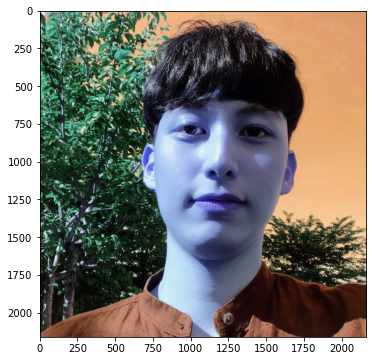

In [483]:
my_image_path = 'images/selfie.png' 
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy() 
plt.figure(figsize=(6, 6))
plt.imshow(img_bgr) 
plt.show()

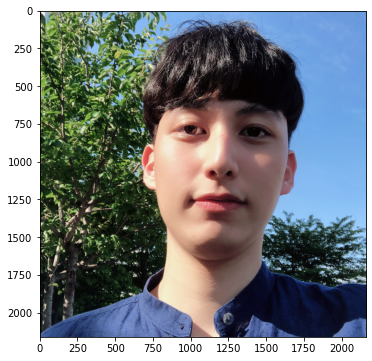

In [484]:
# plt.imshow 이전에 BGR을 RGB 이미지로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb) 
plt.show() 

#### step 2 : 얼굴 검출 & 키포인트 검출

In [485]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [486]:
# 얼굴 영역 검출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(723, 511) (1682, 1469)]]


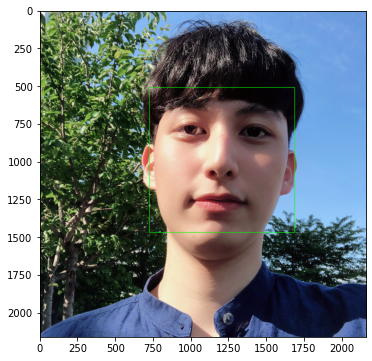

In [487]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_show_rgb)
plt.show()

In [488]:
model_path = 'models/shape_predictor_68_face_landmarks.dat'

# 얼굴의 keypoint 검출하는 landmark_predictor
# RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
landmark_predictor = dlib.shape_predictor(model_path)

In [489]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    # list_landmarks에 랜드마크 리스트를 저장
    list_landmarks.append(list_points)
        
# 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
# 각 원소는 68개의 랜드마크 위치가 나열된 list
print(len(list_landmarks[0]))

68


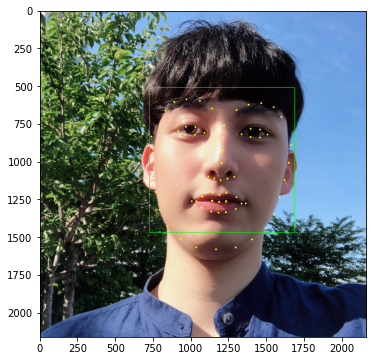

In [490]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 6, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_show_rgb)
plt.show()

#### step 3 : 스티커 적용할 키포인트 선정

1. y값에 offset을 준 이유?  
: 30번(코끝)을 y 좌표로 설정하면 고양이 코가 정확한 위치보다 아래에 위치하고, 33번을 y 좌표로 설정하면 보다 더 위쪽에 놓이게 되어 33번과 30번 위치의 중간값으로 y 좌표를 설정하였다.  
2. 수염의 길이에 해당하는 w는 셀카 각도가 틀어질 경우 얼굴영역 전체 너비에 맞추기보다는 입의 위치와 각도에 맞추기 위해 입 가로 길이의 2배로 설정

In [491]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print(landmark[30]) # 코의 index는 30 입니다
    
    # 고양이 코의 위치가 33번과 30번 사이에 오도록 offset 설정
    offset = (landmark[33][1] - landmark[30][1])//2
    
    x = landmark[30][0]  # 이미지에서 코끝 부위의 x값
    y = landmark[30][1] + offset  # 이미지에서 코끝 부위의 y값 + offset
    h = dlib_rect.height()  # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    w = (landmark[64][0] - landmark[48][0]) * 2
    
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(1200, 1010)
(x,y) : (1200,1067)
(w,h) : (658,959)


#### step 4 : 스티커 적용  

In [492]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape)

(959, 658, 3)


In [493]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 
# 이미지 시작점은 top-left 좌표이기 때문입니다.
refined_x = x - w // 2 
refined_y = y - h // 2 

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (871,588)


스티커 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요하다. 이를 위해 음수 값만큼 스티커 이미지를 자른다.

In [494]:
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (871,588)


스티커 이미지에서 사용할 부분은 색이 있는 부분을 사용합니다. 그렇기 때문에 나머지 흰색 배경부분, 즉 픽셀값이 255인 부분은 제외하고 적용합니다. 
sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.

In [495]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# np.where(condition, x, y) : condition이 참이면 x를, 거짓이면 y 적용
# img_sticker==255이면 원본 이미지를 그대로 적용하고, 그렇지 않으면 img_sticker(고양이 수염)
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

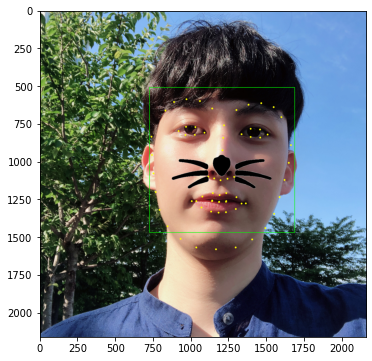

In [496]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

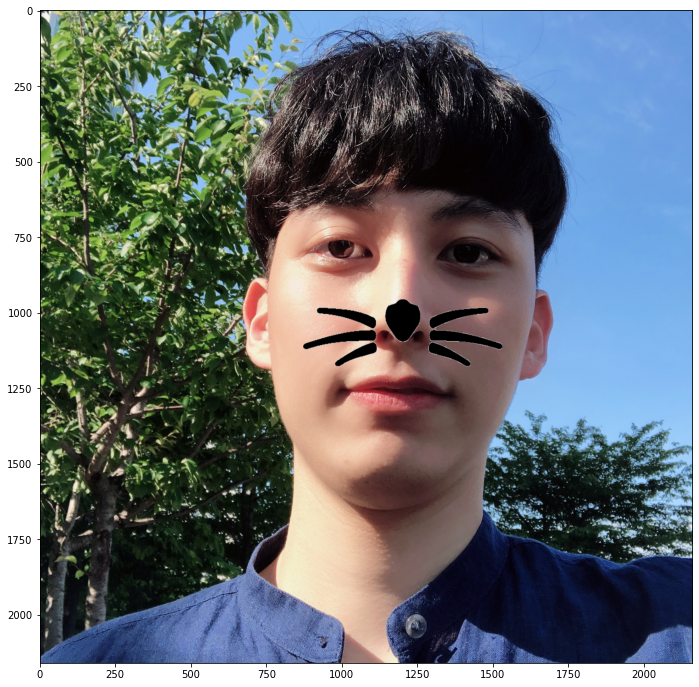

In [497]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

#### step 5 : 피드백 & 회고  

다양한 각도와 거리에서 촬영한 이미지에 대한 결과

![alt text](./results/result_tilt.png)  
![alt text](./results/result_upper_left.png)  
![alt text](./results/result_trump.png)

- 옆에서 찍은 이미지의 경우, 얼굴 bounding box 전체가 아닌 입 크기에 맞게 가로 폭이 바뀌는 것을 확인
- 1번과 3번 사진의 경우 고개가 옆으로 숙여진 상태에서 찍은 것인데, 이 때는 얼굴 각도에 맞게 수염이 돌아가는 것에 대한 구현이 아직 안되어있어 가능하다면 추후에 보완해볼 계획이다.